In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as T

import os
from time import time
import random
import shutil
from datetime import datetime
from collections import defaultdict

from models.unet_inceptionresnetv2 import unet_inceptionresnetv2, UNetInceptionResnetV2, UNetUp2
from models.albunet import AlbuNet
from models.unet import MobilenetV2, InceptionResnetV2, Resnet34_upsample
from loss import BCEDiceLoss

pjoin = join = os.path.join

In [2]:
!nvidia-smi

Fri Jun 29 15:09:10 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.26                 Driver Version: 396.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
| 20%   26C    P8    16W / 250W |  10836MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0 Off |                  N/A |
| 20%   29C    P8    17W / 250W |  10631MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
def make_smooth(x, tau=0.9):
    out = x[:]
    for i in range(1, len(x)):
        out[i] = out[i - 1] * tau + out[i] * (1 - tau)
    return out

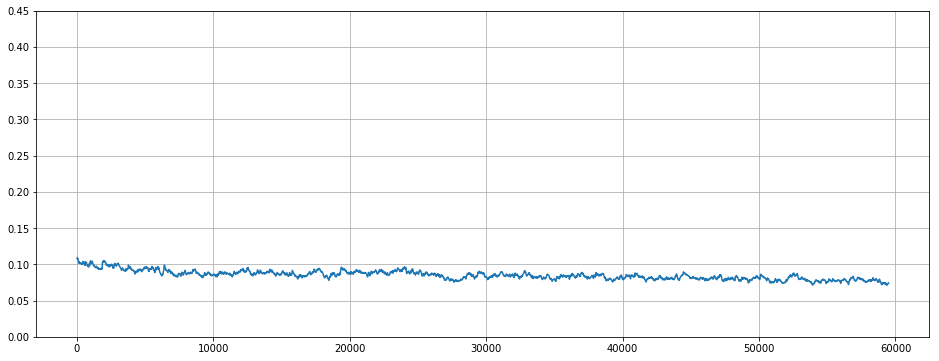

In [63]:
log_path = './output/res50_i512_ch128_dice0.5_train+val/train_log.txt'
#     log_path = './output/mobilenet_i512_b8_lr_decay_1e-4_jaccard/train_log.txt'
lines= [x.strip() for x in open(log_path).readlines() if 'Stage' in x]
data = defaultdict(list)
for l in lines:
    for tok in l.split(',')[1:]:
        tok2 = tok.strip().split(' ')
        key = tok2[0].replace(':','')
        val = float(tok2[1])
        data[key].append(val)

# fig, ax1 = plt.subplots(figsize=(16,8))
# ax1.plot(data['iter'][5:], make_smooth(data['loss'][5:]))
# ax1.grid()
# ax2 = ax1.twinx()
# ax2.plot(val_it, val_iou)

plt.subplots(figsize=(16,6))
plt.plot(data['iter'][1:], make_smooth(data['loss'][1:], tau=.95))
# plt.plot(data_old['iter'][5:], make_smooth(data_old['loss'][5:]))
plt.yticks(np.arange(0, .5, 0.05))
plt.grid()

In [6]:
!tail {log_path}

2018-06-15T19:53:01.704554 Stage: train, iter: 55360, lr: 2.500e-06, loss 0.063481
2018-06-15T19:53:14.813211 Stage: train, iter: 55380, lr: 2.500e-06, loss 0.101839
2018-06-15T19:53:27.903843 Stage: train, iter: 55400, lr: 2.500e-06, loss 0.037013
2018-06-15T19:53:41.001015 Stage: train, iter: 55420, lr: 2.500e-06, loss 0.070909
2018-06-15T19:53:54.087220 Stage: train, iter: 55440, lr: 2.500e-06, loss 0.063769
2018-06-15T19:54:07.186119 Stage: train, iter: 55460, lr: 2.500e-06, loss 0.044086
2018-06-15T19:54:20.542989 Stage: train, iter: 55480, lr: 2.500e-06, loss 0.073199
2018-06-15T19:54:33.640289 Stage: train, iter: 55500, lr: 2.500e-06, loss 0.082209
2018-06-15T19:54:46.739689 Stage: train, iter: 55520, lr: 2.500e-06, loss 0.047621
2018-06-15T19:54:59.836375 Stage: train, iter: 55540, lr: 2.500e-06, loss 0.044518


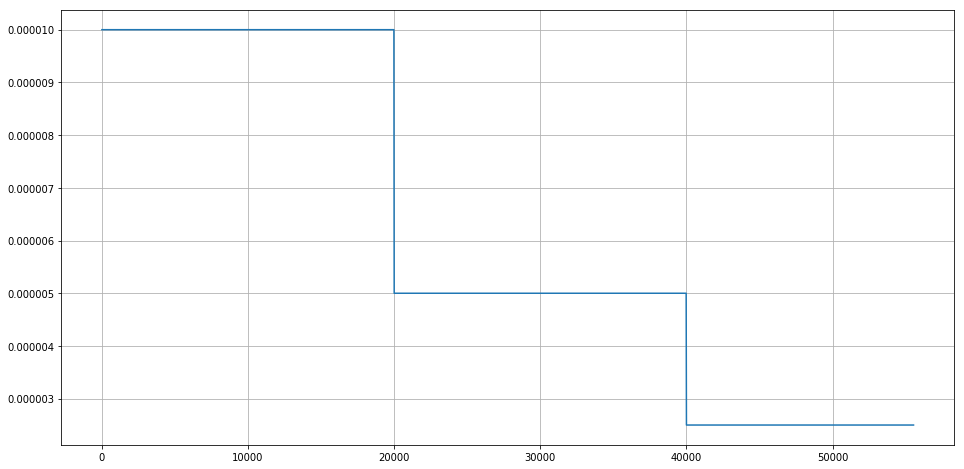

In [7]:
plt.figure(figsize=(16,8))
plt.plot(data['iter'], data['lr'])
plt.grid()

In [9]:
DATA_ROOT = '/mnt/data/comps/AerialImageDataset/'

OUTPUT_DIR = './output/'

ORIG_IMAGE_SZ = 1250

In [10]:
out_ch = 1

criterion = BCEDiceLoss()

model_class = Resnet34_upsample

def get_model():
    model = nn.DataParallel(model_class(out_ch, 3))
    model.cuda()
    return model

if model_class in (MobilenetV2, Resnet34_upsample):
    pretrained_settings = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
elif model_class in (InceptionResnetV2,):
    pretrained_settings = {'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5]}

In [11]:
def ocv_loader(fpath):
    im = cv2.imread(fpath)
    return im[:, :, ::-1].copy() if im is not None else None
        
        
normalizer = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=pretrained_settings['mean'], std=pretrained_settings['std']),
])


class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.FloatTensor(mean)
        self.std = torch.FloatTensor(std)
        
    def __call__(self, img):
        img = img.permute(1, 2, 0)
        return img * self.std + self.mean


denormalizer = Denormalize(pretrained_settings['mean'], pretrained_settings['std'])


def mask_overlay(image, mask, ch=0):
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()
    if mask.ndim > 2:
        mask = mask[ch,:,:]
    if isinstance(image, str):
        im = cv2.imread(image)
        im = cv2.resize(im, (mask.shape[1], mask.shape[0]))
    else:
        im = denormalizer(image).numpy()
        im = (im * 255).astype(np.uint8)
    mask_ch = np.clip((255*mask) + im[...,0], 0, 255).astype(np.uint8)
    return np.dstack((mask_ch,im[...,1],im[...,2]))


def variable(x, volatile=False):
    return Variable(x, volatile=volatile).cuda()


# func to show image
def imshow(im,figsz=(12,12),capt=None,**kwargs):
    plt.figure(figsize=figsz)
    plt.imshow(im,**kwargs)
    if capt:
        plt.title(capt)
    plt.axis('off')

In [12]:
def train_val_split(cities=None):
    def get_city_n(s):
        for i, c in enumerate(s):
            if c.isdigit():
                break
        return int(s[i:])

    train_fnames, val_fnames = [], []
    for fname in os.listdir(pjoin(DATA_ROOT, 'train', 'images')):
        fname = fname[:-4]
        if cities:
            if not sum([x in fname for x in cities]):
                continue
        if get_city_n(fname) < 6:
            val_fnames.append(fname)
        else:
            train_fnames.append(fname)
    return train_fnames, val_fnames


def prepare_data(img, mask):
    img = normalizer(img)
    mask = torch.from_numpy(mask / 255).unsqueeze(0).float()
    return img, mask

In [13]:
def fix_shape(img):
    if model_class == UNetInceptionResnetV2:
        pad = 31 - img.shape[0] % 32
    else:
        pad = 32 - img.shape[0] % 32
    pads = [[0, pad], [0, pad]]
    if img.ndim == 3:
        pads += [[0, 0]]
    return np.pad(img, pads, 'symmetric')


def one_batch(img, gt):
    img, gt = prepare_data(img, gt)
    img, gt = img.unsqueeze(0), gt.unsqueeze(0)
    return variable(img, volatile=True), variable(gt)


def calc_loss(model, criterion, file_names, return_list=False):
    model.eval()
    losses = []
    for i, fname in enumerate(file_names):
        image_path = pjoin(IMAGES_ROOT, fname)
        gt_path = pjoin(GT_ROOT, fname)
        img = ocv_loader(image_path)
        gt = ocv_loader(gt_path)[:, :, 0]
        img, gt = fix_shape(img), fix_shape(gt)
        img, gt = one_batch(img, gt)
        output = model(img)
        losses.append(criterion(output, gt).data[0])
    return np.mean(losses)

In [39]:
# >>> CHECK INCLUDED CITIES <<<
# cities = ['vienna']
cities = []
train_set, val_set = train_val_split(cities)

In [15]:
model = get_model()

In [64]:
model_path = f'./output/res50_i512_ch128_dice0.5_train+val/model_last.pt'
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval();

In [65]:
# for i in range(nh):
#     top, bottom = i * sh, i * sh + h
#     top2 = top if i == 0 else top + (h-sh)//2
#     bottom2 = bottom if i == nh - 1 else bottom - (h-sh)//2
#     top3 = 0 if i == 0 else (h-sh)//2
#     bottom3 = h if i == nh - 1 else h - (h-sh)//2
#     for j in range(nw):
#         left, right = j * sw, j * sw + w
#         patch = img[top:bottom, left:right]
#         left2 = left if j == 0 else left + (w-sw)//2
#         right2 = right if j == nw - 1 else right - (w-sw)//2
#         left3 = 0 if j == 0 else (w-sw)//2
#         right3 = w if j == nw - 1 else w - (w-sw)//2
#         # do smth with patch
#         final[top2:bottom2, left2:right2] += patch[top3:bottom3, left3:right3]

In [ ]:
# #############################################################
save_val_mask = True
dataset = 'test'

W = H = 5000
w = h = 1024*2
sw = sh = 512*2

prediction_threshold = 0.3
# #############################################################


def pad_image(img, padw, padh):
    pads = [[0, padw], [0, padh]]
    if img.ndim == 3:
        pads += [[0, 0]]
    return np.pad(img, pads, 'symmetric')

def output2pred(output, ch=0):
    return torch.sigmoid(output).data[0].cpu().numpy()[ch]

def prepare_img(img, eval_mode=True):
    img = normalizer(img)
    if len(img.shape) == 3:
        img = img.unsqueeze(0)
    return variable(img, volatile=eval_mode)

def make_dir(path, remove_exists=False):
    if os.path.exists(path):
        print(f'WARNING: {path} exists')
        if remove_exists:
            shutil.rmtree(path)
    try:
        os.mkdir(prediction_output_dir)
    except FileExistsError:
        pass

def iou(pred, target, thr=prediction_threshold):
    pred = (pred > thr).astype(int)
    intersection = (pred * target).sum()
    return intersection / (pred.sum() + target.sum() - intersection + 1e-12)


def prediction2mask(prediction):
    return np.uint8(prediction > prediction_threshold) * 255
    
    
exp_name = model_path.split('/')[-2]
prediction_output_dir = f'./output/{exp_name}_prediction/'
make_dir(prediction_output_dir)


assert (w - sw) % 2 == 0 and (h - sh) % 2 == 0

modw, modh = (W - w) % sw, (H - h) % sh
padw = sw - modw if modw else 0 
padh = sh - modh if modh else 0
nw = (W - w) // sw + 1 + int(modw > 0)
nh = (H - h) // sh + 1 + int(modh > 0)
print(f'nw {nw}, nh {nh}, padw {padw}, padh {padh}')


predict_start = time()

if dataset == 'test':
    image_root = DATA_ROOT + 'test/images/'
    gt_root = None
    image_list = os.listdir(image_root)
else:
    image_root = DATA_ROOT + 'train/images/'
    gt_root = DATA_ROOT + 'train/gt/'
    #image_list = set(['-'.join(x.split('-')[:-1])+'.tif' for x in val_set])
    if dataset == 'val':
        image_list = sorted([x + '.tif' for x in val_set])
    else:
        image_list = sorted([x + '.tif' for x in train_set])

    
ious = []
for city in image_list:
    #city='austin2.tif'
    img = ocv_loader(pjoin(image_root, city))
    if dataset != 'test':
        gt = ocv_loader(pjoin(gt_root, city))[:, :, 0]

    #imshow(cv2.resize(img, None, None, 0.5, 0.5))
    #imshow(cv2.resize(gt, None, None, 0.5, 0.5))

    #print(img.shape)

    img_pad = pad_image(img, padw, padh)
    #imshow(cv2.resize(img, None, None, 0.5, 0.5))

    overlap_map = np.zeros((H + padh, W + padw), dtype=np.float32)
    prediction = np.zeros((H + padh, W + padw), dtype=np.float32)
    for i in range(nh):
        top, bottom = i * sh, i * sh + h
        for j in range(nw):
            left, right = j * sw, j * sw + w
            img_patch = img_pad[top:bottom, left:right]
            pred_patch = output2pred(model(prepare_img(img_patch)))
                
            # TTA
            flip_codes = [-1, 0, 1]
            #flip_codes = []
            for fc in flip_codes:
                img_tta = cv2.flip(img_patch, fc)
                pred_tta = output2pred(model(prepare_img(img_tta)))
                pred_patch += cv2.flip(pred_tta, fc)
            n_tta = 1 + len(flip_codes)
            pred_patch /= n_tta
            
            left2 = left if j == 0 else left + (w-sw)//2
            right2 = right if j == nw - 1 else right - (w-sw)//2
            top2 = top if i == 0 else top + (h-sh)//2
            bottom2 = bottom if i == nh - 1 else bottom - (h-sh)//2
            left3 = 0 if j == 0 else (w-sw)//2
            right3 = w if j == nw - 1 else w - (w-sw)//2
            top3 = 0 if i == 0 else (h-sh)//2
            bottom3 = h if i == nh - 1 else h - (h-sh)//2
            prediction[top2:bottom2, left2:right2] = pred_patch[top3:bottom3, left3:right3]
            
            #prediction[top:bottom, left:right] += pred_patch
            #overlap_map[top:bottom, left:right] += 1
            
            #print(pred_patch.max())
            #imshow(pred_patch)
    #prediction /= overlap_map
    prediction = prediction[:H, :W]
    
    if dataset == 'test':
        prediction_mask = prediction2mask(prediction)
        prediction_path = pjoin(prediction_output_dir, city)
        cv2.imwrite(prediction_path, prediction_mask)
    else:
        iou1 = iou(prediction, (gt // 255).astype(int)) 
        print(city, iou1)
        ious.append(iou1)
        if save_val_mask:
            pred_gt_olay = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
            pred_gt_olay[..., 2] = prediction2mask(prediction)
            pred_gt_olay[..., 1] = img[..., 0]
            pred_gt_olay[..., 0] = gt
            prediction_path = pjoin(prediction_output_dir, city)
            cv2.imwrite(prediction_path, pred_gt_olay)
    
pred_sec = int(time() - predict_start)
print(f'prediction took {pred_sec//60}min and {pred_sec%60}sec')

nw 4, nh 4, padw 120, padh 120


In [67]:
iou_per_city = defaultdict(float)
for city, iou1 in zip(image_list, ious):
    iou_per_city[city.split('.')[0][:-1]] += iou1
for city, iou1 in iou_per_city.items():
    print(f'{city}: {iou1/5:.4f}')
overall_iou = np.mean(ious)
print('---')
print(f'overall: {overall_iou:.4f}') 

austin: 0.8439
chicago: 0.7866
kitsap: 0.7104
tyrol-w: 0.8517
vienna: 0.8602
---
overall: 0.8106


In [60]:
np.mean(ious)

#120 0.8140715284940416
#160 0.8203615256931048
#200 0.8223337819466279
#iou.25 0.8208387258407432
#iou.3 0.8223337819466279
#iou.3 0.8229529743119594 - dice2
#iou.3 0.8223203891712896 - dice2 (60k it)
#iou.35 0.8231644555340811
#iou.4 0.8234608150611973
#iou.5 0.8228419762940581

#tta@iou.4 0.8333602882294786
#tta@iou.4 0.8333602882294786

# it, criteria, lr_sched, score
# 120, jaccard, 1/3.33 decay each 20k it, 0.7329318480092456


0.7787547373138983

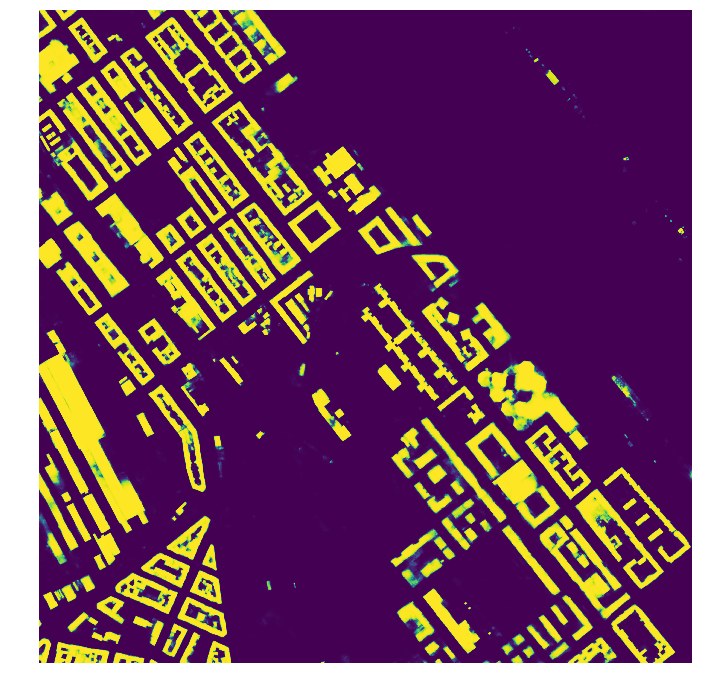

In [24]:
imshow(prediction)